# Person Re-ID Keras Baseline

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.datasets.reid import TripletDataGenerator, TestingDataGenerator
from vbranch.applications.resnet import ResNet50
from vbranch.callbacks import reid_acc
from vbranch.losses import _triplet, triplet

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data_iterator_from_generator, lr_exp_decay_scheduler
from vbranch.utils.test.reid import _evaluate_metrics

Using TensorFlow backend.


In [3]:
# from keras.applications.resnet50 import ResNet50
# from keras.applications.densenet import DenseNet121
from keras.layers import Input, Dense, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import Progbar
from keras import backend

In [4]:
SAVE = True
MODEL_ID = 1
ARCHITECTURE = 'resnet'
DATASET = 'market'
NUM_BRANCHES = 1
SHARED_FRAC = 0.5

EPOCHS = 250
STEPS_PER_EPOCH = 100
T_0 = 150
OUTPUT_DIM = 128

## Load Data

In [5]:
P, K = 18, 4
train_generator = TripletDataGenerator(DATASET, 'train')

In [6]:
batch = train_generator.next(4, 4, flatten=True, preprocess=ARCHITECTURE)
# for i in range(4):
#     for j in range(4):
#         plt.subplot(4, 4, 4*i+j+1)
#         plt.imshow(batch[i, j].squeeze(), cmap=plt.cm.gray)
#         plt.axis('off')
# plt.show()

In [7]:
batch.min(), batch.max()

(-119.68, 151.061)

In [8]:
test_gen = TestingDataGenerator(DATASET, 'test', preprocess=ARCHITECTURE)

In [9]:
def generator():
    while True:
        batch = train_generator.next(P, K, flatten=True, preprocess=ARCHITECTURE, labels=True)
        yield batch

## Build Model

In [10]:
def get_score(sess, model):
    gallery_data = TestingDataGenerator(DATASET, 'test', preprocess=ARCHITECTURE, 
                                        img_dim=(256,128,3), buffer=100)
    query_data = TestingDataGenerator(DATASET, 'query', preprocess=ARCHITECTURE, 
                                      img_dim=(256,128,3), buffer=100)

    gallery_embs = []
    for batch in gallery_data:
#         gallery_embs.append(model.predict(batch))
#         gallery_embs.append(sess.run(model.output, feed_dict={model.input:batch, 
#                                                               backend.learning_phase():1}))
        sess.run(test_init_op, feed_dict={'x:0':batch, 'batch_size:0':len(batch)})
        gallery_embs.append(sess.run(model.output))
    query_embs = []
    for batch in query_data:
#         query_embs.append(model.predict(batch))
#         query_embs.append(sess.run(model.output, feed_dict={model.input:batch,
#                                                             backend.learning_phase():1}))
        sess.run(test_init_op, feed_dict={'x:0':batch, 'batch_size:0':len(batch)})
        query_embs.append(sess.run(model.output))

    gallery_embs = np.concatenate(gallery_embs, axis=0)
    query_embs = np.concatenate(query_embs, axis=0)

    rank_score, mAP_score = _evaluate_metrics(gallery_embs, query_embs,
        gallery_data, query_data, [1,5])
    return rank_score, mAP_score

In [11]:
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

inputs, train_init_op, test_init_op = get_data_iterator_from_generator(train_generator, input_dim, 
                                                                       P,K, ARCHITECTURE,
                                                                       n=NUM_BRANCHES)

(None, 256, 128, 3)
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [12]:
with TFSessionGrow() as sess:
#     # input_layer = Input(shape=(256,128,3))
#     input_layer = Input(tensor=inputs)
#     base_model = ResNet50(input_tensor=input_layer, weights='imagenet', include_top=False)
#     # base_model = DenseNet121(input_tensor=input_layer, weights='imagenet', include_top=False)

#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(1024)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dense(OUTPUT_DIM, name='output')(x)
#     model = Model(input_layer, x)

    model = ResNet50(inputs, OUTPUT_DIM, name='model')

#     model.compile(loss=triplet(P,K), optimizer=Adam(lr=0.0003))
    loss_op = _triplet(model.output, P, K)
    train_op = tf.train.AdamOptimizer(learning_rate=0.0003).minimize(loss_op)
    
#     print(model.layers[2].get_weights()[1])
#     print(sess.run('conv1/bias:0'))
    sess.run(tf.global_variables_initializer())
#     sess.run(assign_ops)
    
    for i in range(10):
#         model.fit_generator(generator(), steps_per_epoch=100, epochs=1)
#         print(get_score(sess, model))
        sess.run(train_init_op)
        for e in range(10):
            print('Epoch {}/{}'.format(i*10+e+1, 100))
            progbar = Progbar(STEPS_PER_EPOCH)
            for s in range(STEPS_PER_EPOCH):
#                 batch, _ = next(generator())
                _, loss = sess.run([train_op, loss_op], 
                                   feed_dict={backend.learning_phase():1})
                progbar.update(s+1, values=[('loss', loss)])
                
        print(get_score(sess, model))
    
#     print(model.layers[2].get_weights()[1])
#     print(sess.run('conv1/bias:0'))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
100/100 [==============================] - 69s 689ms/step - loss: 685.0399
Epoch 2/100
100/100 [==============================] - 56s 559ms/step - loss: 190.0788
Epoch 3/100
100/100 [==============================] - 56s 559ms/step - loss: 153.2602
Epoch 4/100
100/100 [==============================] - 56s 560ms/step - loss: 131.7398
Epoch 5/100
100/100 [==============================] - 56s 561ms/step - loss: 124.1589
Epoch 6/100
100/100 [==============================] - 56s 560ms/step - loss: 115.1269
Epoch 7/100
100/100 [==============================] - 56s 559ms/step - loss: 112.4866
Epoch 8/100
100/100 [==============================] - 56s 558ms/step - loss: 108.7483
Epoch 9/100
100/100 [==============================] - 56s 561ms/step - loss: 105.1831
Epoch 10/100
100/100 [==============================] - 57s 567ms/step - loss: 103.7856
Sta

KeyboardInterrupt: 

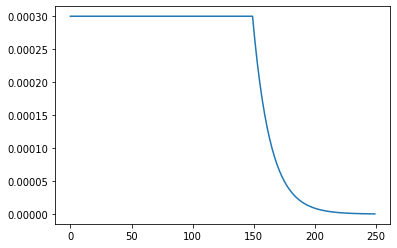

In [12]:
lr_scheduler = lr_exp_decay_scheduler(0.0003, T_0, EPOCHS, 0.001)
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [13]:
with TFSessionGrow() as sess:
    
    
    lr = tf.placeholder('float32', name='lr')
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    loss_op = _triplet(model.output, P, K)
    train_op = optimizer.minimize(loss_op)
    
    sess.run(tf.global_variables_initializer())
    
#     weights_model = ResNet50(weights='imagenet', include_top=False)
    weights_model = DenseNet121(weights='imagenet', include_top=False)
    
    for i, layer in enumerate(weights_model.layers):
        model.layers[i].set_weights(layer.get_weights())
#     print(sess.run('conv1/bias:0'))
    
    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH, verbose=2)

        sess.run(train_init_op)
        lr_val = lr_scheduler(e+1)
        
        if e == 0:
            batch = sess.run('input:0')
            print(batch.min(), batch.max())
        
        for i in range(STEPS_PER_EPOCH):
            loss, _ = sess.run([loss_op, train_op], feed_dict={lr:lr_val})
            progbar_vals = [('lr', lr_val), ('loss', loss)]
            
            if i == STEPS_PER_EPOCH - 1 and (e + 1) % 10 == 0:
                print(reid_acc(DATASET, preprocess=ARCHITECTURE)(sess))

            # Update progress bar
            progbar.update(i+1, values=progbar_vals)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/250
-2.117904 2.64
 - 68s - lr: 3.0000e-04 - loss: 57.4178
Epoch 2/250
 - 51s - lr: 3.0000e-04 - loss: 16.1963
Epoch 3/250
 - 51s - lr: 3.0000e-04 - loss: 15.3216
Epoch 4/250
 - 51s - lr: 3.0000e-04 - loss: 14.9620
Epoch 5/250
 - 51s - lr: 3.0000e-04 - loss: 14.7497
Epoch 6/250
 - 51s - lr: 3.0000e-04 - loss: 14.6479
Epoch 7/250
 - 51s - lr: 3.0000e-04 - loss: 14.6139
Epoch 8/250
 - 51s - lr: 3.0000e-04 - loss: 14.5685
Epoch 9/250
 - 51s - lr: 3.0000e-04 - loss: 14.6943
Epoch 10/250
Computing gallery embeddings...
15913/15913 [==============================] - 40s 2ms/step
Computing query embeddings...
3368/3368 [==============================] - 8s 2ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 20.024890661239624
{'mAP': 0.046499834629100824, 'rank1': 0.10095012, 'rank5': 0.23693587}
 - 120s - lr: 3.00

KeyboardInterrupt: 

In [ ]:
model.layers[2].get_weights()[1]

In [17]:
tf.global_variables()

[<tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/moving_mean/biased:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/moving_mean/local_step:0' shape=() dtype=float32_ref>,
 <tf.Variable 'bn_conv1/moving_variance/biased:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/moving_variance/local_step:0' shape=() dtype=float32_ref>,
 <tf.Variable 'res2a_branch2a/kernel:0' shape=(1, 1, 64, 64) dtype=float32_ref>,
 <tf.Variable 'res2a_branch2a/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn2a_branch2a/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn2a_branch2a/beta:0' shape=(64,) d